### Training a correlated posterior estimate

Here we train on data simulated with a nonlinear model of fluorescence dynamics.
We use a combination of convolutional and recurrent networks. 

The procedure is identical to the first notebook, the only difference is the employed recognition model.

For this example a GPU is required to train the model in reasonable time.

In [1]:
import sys
import os
sys.path.append("engine/")
sys.path.append("funcs/")
sys.setrecursionlimit(10000)

import theano.gpuarray
theano.gpuarray.use('cuda0')

import theano
import theano.tensor as T
from theano import config
import numpy as np
import pickle
import copy
import time
from itertools import *
from tqdm import tqdm

from RecognitionModel import *
from VIMCO_alpha import *
from plot_funcs import *

from matplotlib import pyplot as plt
from matplotlib import gridspec
%matplotlib inline

Using cuDNN version 6021 on context None
Preallocating 10986/12207 Mb (0.900000) on cuda0
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:03:00.0)


In [2]:
rng = np.random.RandomState(1)
lasagne.random.set_rng(rng)

n_cells = 100
timebins = 10000
fps = 60
fRate = [0.7,1.,1.2]
fProb = [f/fps for f in fRate]

traces_foopsi = []
spikes_foopsi = []

TrueParams_foopsi = []
InitParameters = {}

low = {"gamma": 2.5, "alpha": .2, "beta": -0.2, "sigma": 0.02, "kappa": 2.0, "eta": -5.9,  "zeta": 0.5, "d_max": 5.5}
high = {"gamma": 3.5, "alpha": .5, "beta": -0.2, "sigma": 0.05, "kappa": 2.5, "eta": -4.9,  "zeta": 1.0, "d_max": 6.5}

gen_model = SCDF(low)

for i in tqdm(range(n_cells)):
    
    InitParameters = {}
    for p in low:
        if low[p] < high[p]:
            InitParameters.update({p:rng.randint(1000*low[p],1000*high[p])/1000}) 
        else:
            InitParameters.update({p:low[p]})
    
    gen_model.set_params(InitParameters)
    sim_spikes = []
    for f in fProb:
        sim_spikes.append(rng.binomial(1, f, (timebins)))
        
    sim_spikes = np.array(sim_spikes).astype(config.floatX)
    sim_fluor = gen_model.genfunc(sim_spikes) + rng.normal(size=(sim_spikes.shape)) * InitParameters['sigma']
    traces_foopsi.append(copy.deepcopy(sim_fluor))
    spikes_foopsi.append(copy.deepcopy(sim_spikes))
    TrueParams_foopsi.append(copy.deepcopy(InitParameters))

100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


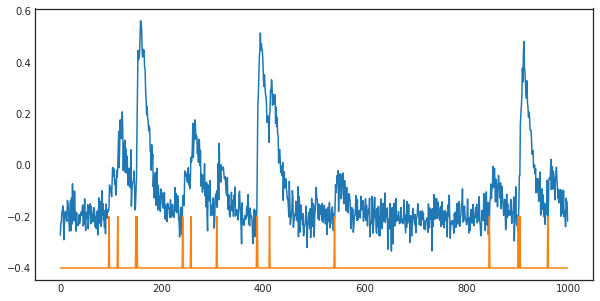

In [3]:
plt.figure(figsize = (10,5))
plt.plot(sim_fluor[0][:1000])
plt.plot(sim_spikes[0][:1000]/5-0.4)

In [4]:
data = {'traces': np.array(traces_foopsi).astype(config.floatX), 'spikes': np.array(spikes_foopsi).astype(config.floatX), 'params': TrueParams_foopsi, 'fps':[fps for _ in range(n_cells)], 'spike_fps':60}

with open('scdf_100.pkl', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [5]:
# timebins = 250
timebins = 250

with open('scdf_100.pkl', 'rb') as f:
    data = pickle.load(f)

n_cells = 30

Traces_train = data['traces']
Spikes_train = data['spikes']
truths = data['params']

sv_Traces,sv_Spikes = data_chop(timebins, Traces_train[:n_cells], Spikes_train[:n_cells], [])

In [20]:
init_params = {'d_max': 6, 'alpha': .7, 'beta': -0.2, 'eta': -5.0, 'gamma': 3.0, 'kappa': 2.0, 'sigma': -4, 'zeta': 0.8}
inf_params = None

# The recognition network is initialized with additional parameters to indicate that the CNN is used as the initial stage of a RNN. The RNN is initialized in the 'GRUX_BernoulliRecognition' class.
recDict = set_rec_net([20,15,15,15],[31,21,21,11], FB = True, AR = True, n_rnn_units = 64, n_genparams=0)

model = VIMCO(init_params, inf_params, SCDF, recDict, GRUX_BernoulliRecognition, batch_size=30, n_samples = 64, n_cells = n_cells, rng = rng, filename = 'scdf_model')

model.true_params = [t for t in truths]

model.gen_lr_fac = 15
model.lr_decay = np.array(0.995, dtype=theano.config.floatX)
model.buffers = [100,50]
model.facs = [1]
model.mrec.pz = 0.015
model.gradnorm_clip = 0.02
model.gradnorm_tot = True

model.eval_sets = [{'traces':Traces_train[:n_cells,:,:1000], 'spikes':Spikes_train[:n_cells,:,:1000], 'eval_T':1000, 'eval_rep': 5, 'test_gen':True}]

In [21]:
model.fit(sv_Traces,sv_Spikes,max_epochs= 500, learning_rate = 1e-3, print_freq=100)

/usr/local/lib/python3.5/dist-packages/theano/tensor/basic.py:5262: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


Corr. Train: 0.285 Synchro: 0.381 || MSE Pred./Truth: 4.770 3.145 || Cost: -340.391 || Factor: 0.647 || Time upd./Eval.: 438.4 ms 3.8 s || BatchNr.: 100
Corr. Train: 0.368 Synchro: 0.489 || MSE Pred./Truth: 4.226 2.889 || Cost: -15.324 || Factor: 0.874 || Time upd./Eval.: 463.8 ms 2.8 s || BatchNr.: 200
Corr. Train: 0.391 Synchro: 0.589 || MSE Pred./Truth: 3.168 2.592 || Cost: -10.088 || Factor: 0.905 || Time upd./Eval.: 466.8 ms 2.8 s || BatchNr.: 300
Corr. Train: 0.365 Synchro: 0.609 || MSE Pred./Truth: 2.228 2.245 || Cost: -0.283 || Factor: 0.691 || Time upd./Eval.: 467.7 ms 2.8 s || BatchNr.: 400
Corr. Train: 0.410 Synchro: 0.703 || MSE Pred./Truth: 2.040 2.323 || Cost: -8.512 || Factor: 0.821 || Time upd./Eval.: 464.7 ms 2.8 s || BatchNr.: 500
Corr. Train: 0.388 Synchro: 0.768 || MSE Pred./Truth: 2.162 2.036 || Cost: -2.411 || Factor: 1.000 || Time upd./Eval.: 452.1 ms 2.6 s || BatchNr.: 600
Corr. Train: 0.479 Synchro: 0.783 || MSE Pred./Truth: 2.233 1.885 || Cost: 1.610 || Factor

Corr. Train: 0.583 Synchro: 0.777 || MSE Pred./Truth: 1.662 1.094 || Cost: 3.170 || Factor: 1.304 || Time upd./Eval.: 450.8 ms 2.7 s || BatchNr.: 5600
Corr. Train: 0.567 Synchro: 0.803 || MSE Pred./Truth: 1.439 1.121 || Cost: 3.186 || Factor: 1.202 || Time upd./Eval.: 445.4 ms 2.8 s || BatchNr.: 5700
Corr. Train: 0.562 Synchro: 0.802 || MSE Pred./Truth: 1.459 1.117 || Cost: 3.138 || Factor: 1.083 || Time upd./Eval.: 446.1 ms 2.8 s || BatchNr.: 5800
Corr. Train: 0.569 Synchro: 0.801 || MSE Pred./Truth: 1.685 1.122 || Cost: 3.178 || Factor: 1.247 || Time upd./Eval.: 449.5 ms 2.8 s || BatchNr.: 5900
Corr. Train: 0.546 Synchro: 0.834 || MSE Pred./Truth: 1.352 1.091 || Cost: 3.025 || Factor: 1.041 || Time upd./Eval.: 446.4 ms 2.8 s || BatchNr.: 6000
Corr. Train: 0.601 Synchro: 0.847 || MSE Pred./Truth: 1.462 1.117 || Cost: 3.090 || Factor: 1.088 || Time upd./Eval.: 450.2 ms 2.8 s || BatchNr.: 6100
Corr. Train: 0.579 Synchro: 0.820 || MSE Pred./Truth: 1.740 1.075 || Cost: 3.007 || Factor: 1.

Corr. Train: 0.595 Synchro: 0.836 || MSE Pred./Truth: 1.241 1.021 || Cost: 3.156 || Factor: 1.098 || Time upd./Eval.: 451.2 ms 2.7 s || BatchNr.: 11100
Corr. Train: 0.606 Synchro: 0.841 || MSE Pred./Truth: 1.185 1.027 || Cost: 3.208 || Factor: 0.993 || Time upd./Eval.: 450.6 ms 2.8 s || BatchNr.: 11200
Corr. Train: 0.601 Synchro: 0.843 || MSE Pred./Truth: 1.168 1.021 || Cost: 3.244 || Factor: 1.080 || Time upd./Eval.: 446.9 ms 2.7 s || BatchNr.: 11300
Corr. Train: 0.601 Synchro: 0.822 || MSE Pred./Truth: 1.553 1.052 || Cost: 3.133 || Factor: 1.100 || Time upd./Eval.: 450.8 ms 2.7 s || BatchNr.: 11400
Corr. Train: 0.600 Synchro: 0.827 || MSE Pred./Truth: 1.378 1.025 || Cost: 3.189 || Factor: 1.118 || Time upd./Eval.: 452.0 ms 2.7 s || BatchNr.: 11500
Corr. Train: 0.606 Synchro: 0.840 || MSE Pred./Truth: 1.196 1.009 || Cost: 3.215 || Factor: 1.051 || Time upd./Eval.: 449.2 ms 2.8 s || BatchNr.: 11600
Corr. Train: 0.608 Synchro: 0.828 || MSE Pred./Truth: 1.283 1.032 || Cost: 3.213 || Fact

Corr. Train: 0.618 Synchro: 0.831 || MSE Pred./Truth: 1.244 1.033 || Cost: 3.235 || Factor: 1.124 || Time upd./Eval.: 446.4 ms 2.7 s || BatchNr.: 16500
Corr. Train: 0.613 Synchro: 0.848 || MSE Pred./Truth: 1.229 1.031 || Cost: 3.273 || Factor: 1.062 || Time upd./Eval.: 448.6 ms 2.7 s || BatchNr.: 16600
Corr. Train: 0.611 Synchro: 0.829 || MSE Pred./Truth: 1.128 1.016 || Cost: 3.268 || Factor: 1.120 || Time upd./Eval.: 453.2 ms 2.8 s || BatchNr.: 16700
Corr. Train: 0.624 Synchro: 0.847 || MSE Pred./Truth: 1.180 1.030 || Cost: 3.185 || Factor: 1.051 || Time upd./Eval.: 454.5 ms 2.7 s || BatchNr.: 16800
Corr. Train: 0.627 Synchro: 0.852 || MSE Pred./Truth: 1.203 1.024 || Cost: 3.278 || Factor: 1.029 || Time upd./Eval.: 450.2 ms 2.7 s || BatchNr.: 16900
Corr. Train: 0.604 Synchro: 0.818 || MSE Pred./Truth: 1.680 1.027 || Cost: 3.121 || Factor: 1.125 || Time upd./Eval.: 449.9 ms 2.7 s || BatchNr.: 17000
Corr. Train: 0.616 Synchro: 0.843 || MSE Pred./Truth: 1.105 1.018 || Cost: 3.223 || Fact

Corr. Train: 0.630 Synchro: 0.858 || MSE Pred./Truth: 1.075 1.018 || Cost: 3.173 || Factor: 1.054 || Time upd./Eval.: 456.3 ms 2.8 s || BatchNr.: 21900
Corr. Train: 0.627 Synchro: 0.855 || MSE Pred./Truth: 1.093 1.011 || Cost: 3.167 || Factor: 1.031 || Time upd./Eval.: 451.1 ms 2.8 s || BatchNr.: 22000
Corr. Train: 0.614 Synchro: 0.836 || MSE Pred./Truth: 1.239 1.012 || Cost: 3.291 || Factor: 1.100 || Time upd./Eval.: 452.3 ms 2.7 s || BatchNr.: 22100
Corr. Train: 0.625 Synchro: 0.850 || MSE Pred./Truth: 1.121 1.013 || Cost: 3.192 || Factor: 1.059 || Time upd./Eval.: 451.2 ms 2.7 s || BatchNr.: 22200
Corr. Train: 0.625 Synchro: 0.848 || MSE Pred./Truth: 1.105 1.015 || Cost: 3.246 || Factor: 1.083 || Time upd./Eval.: 456.4 ms 2.7 s || BatchNr.: 22300
Corr. Train: 0.632 Synchro: 0.856 || MSE Pred./Truth: 1.102 1.014 || Cost: 3.157 || Factor: 1.063 || Time upd./Eval.: 449.9 ms 2.9 s || BatchNr.: 22400
Corr. Train: 0.626 Synchro: 0.850 || MSE Pred./Truth: 1.087 1.007 || Cost: 3.298 || Fact

Corr. Train: 0.630 Synchro: 0.856 || MSE Pred./Truth: 1.074 1.006 || Cost: 3.256 || Factor: 1.125 || Time upd./Eval.: 449.5 ms 2.9 s || BatchNr.: 27300
Corr. Train: 0.629 Synchro: 0.864 || MSE Pred./Truth: 1.062 1.016 || Cost: 3.240 || Factor: 1.077 || Time upd./Eval.: 448.4 ms 2.8 s || BatchNr.: 27400
Corr. Train: 0.630 Synchro: 0.851 || MSE Pred./Truth: 1.087 1.008 || Cost: 3.246 || Factor: 1.089 || Time upd./Eval.: 448.3 ms 2.8 s || BatchNr.: 27500
Corr. Train: 0.633 Synchro: 0.862 || MSE Pred./Truth: 1.068 1.013 || Cost: 3.167 || Factor: 1.060 || Time upd./Eval.: 450.2 ms 2.8 s || BatchNr.: 27600
Corr. Train: 0.629 Synchro: 0.868 || MSE Pred./Truth: 1.078 1.009 || Cost: 3.299 || Factor: 1.057 || Time upd./Eval.: 448.2 ms 2.9 s || BatchNr.: 27700
Corr. Train: 0.623 Synchro: 0.858 || MSE Pred./Truth: 1.083 1.010 || Cost: 3.209 || Factor: 1.061 || Time upd./Eval.: 456.4 ms 2.8 s || BatchNr.: 27800
Corr. Train: 0.621 Synchro: 0.865 || MSE Pred./Truth: 1.061 1.011 || Cost: 3.236 || Fact

Corr. Train: 0.640 Synchro: 0.874 || MSE Pred./Truth: 1.058 1.002 || Cost: 3.319 || Factor: 1.050 || Time upd./Eval.: 450.3 ms 3.1 s || BatchNr.: 32700
Corr. Train: 0.630 Synchro: 0.856 || MSE Pred./Truth: 1.060 1.005 || Cost: 3.211 || Factor: 1.084 || Time upd./Eval.: 455.5 ms 2.7 s || BatchNr.: 32800
Corr. Train: 0.639 Synchro: 0.866 || MSE Pred./Truth: 1.132 1.003 || Cost: 3.283 || Factor: 1.036 || Time upd./Eval.: 457.7 ms 2.8 s || BatchNr.: 32900
Corr. Train: 0.628 Synchro: 0.860 || MSE Pred./Truth: 1.065 1.005 || Cost: 3.283 || Factor: 1.043 || Time upd./Eval.: 468.3 ms 2.8 s || BatchNr.: 33000
Corr. Train: 0.620 Synchro: 0.857 || MSE Pred./Truth: 1.077 1.005 || Cost: 3.315 || Factor: 1.071 || Time upd./Eval.: 457.7 ms 2.3 s || BatchNr.: 33100
Corr. Train: 0.632 Synchro: 0.861 || MSE Pred./Truth: 1.058 1.006 || Cost: 3.233 || Factor: 1.055 || Time upd./Eval.: 464.9 ms 2.3 s || BatchNr.: 33200
Corr. Train: 0.631 Synchro: 0.859 || MSE Pred./Truth: 1.123 1.004 || Cost: 3.288 || Fact

Corr. Train: 0.640 Synchro: 0.870 || MSE Pred./Truth: 1.077 1.007 || Cost: 3.266 || Factor: 1.058 || Time upd./Eval.: 482.5 ms 3.0 s || BatchNr.: 38100
Corr. Train: 0.635 Synchro: 0.877 || MSE Pred./Truth: 1.062 1.002 || Cost: 3.321 || Factor: 1.041 || Time upd./Eval.: 471.4 ms 2.5 s || BatchNr.: 38200
Corr. Train: 0.620 Synchro: 0.857 || MSE Pred./Truth: 1.059 1.004 || Cost: 3.174 || Factor: 1.093 || Time upd./Eval.: 475.9 ms 2.8 s || BatchNr.: 38300
Corr. Train: 0.644 Synchro: 0.864 || MSE Pred./Truth: 1.047 1.002 || Cost: 3.300 || Factor: 1.050 || Time upd./Eval.: 474.5 ms 2.7 s || BatchNr.: 38400
Corr. Train: 0.631 Synchro: 0.866 || MSE Pred./Truth: 1.045 1.004 || Cost: 3.223 || Factor: 1.068 || Time upd./Eval.: 471.3 ms 2.8 s || BatchNr.: 38500
Corr. Train: 0.639 Synchro: 0.870 || MSE Pred./Truth: 1.038 1.004 || Cost: 3.272 || Factor: 1.055 || Time upd./Eval.: 467.3 ms 2.7 s || BatchNr.: 38600
Corr. Train: 0.628 Synchro: 0.870 || MSE Pred./Truth: 1.050 1.004 || Cost: 3.280 || Fact

Corr. Train: 0.637 Synchro: 0.865 || MSE Pred./Truth: 1.054 1.003 || Cost: 3.253 || Factor: 1.065 || Time upd./Eval.: 456.1 ms 2.8 s || BatchNr.: 43500
Corr. Train: 0.638 Synchro: 0.874 || MSE Pred./Truth: 1.054 1.003 || Cost: 3.232 || Factor: 1.061 || Time upd./Eval.: 467.8 ms 2.7 s || BatchNr.: 43600
Corr. Train: 0.627 Synchro: 0.857 || MSE Pred./Truth: 1.051 1.002 || Cost: 3.245 || Factor: 1.072 || Time upd./Eval.: 456.1 ms 2.7 s || BatchNr.: 43700
Corr. Train: 0.639 Synchro: 0.865 || MSE Pred./Truth: 1.106 1.003 || Cost: 3.260 || Factor: 1.066 || Time upd./Eval.: 460.5 ms 2.8 s || BatchNr.: 43800
Corr. Train: 0.640 Synchro: 0.859 || MSE Pred./Truth: 1.115 1.002 || Cost: 3.277 || Factor: 1.100 || Time upd./Eval.: 454.2 ms 2.7 s || BatchNr.: 43900
Corr. Train: 0.647 Synchro: 0.877 || MSE Pred./Truth: 1.077 1.003 || Cost: 3.289 || Factor: 1.067 || Time upd./Eval.: 454.8 ms 2.7 s || BatchNr.: 44000
Corr. Train: 0.640 Synchro: 0.875 || MSE Pred./Truth: 1.059 1.002 || Cost: 3.230 || Fact

Corr. Train: 0.645 Synchro: 0.871 || MSE Pred./Truth: 1.034 1.002 || Cost: 3.187 || Factor: 1.043 || Time upd./Eval.: 457.7 ms 2.8 s || BatchNr.: 48900
Corr. Train: 0.644 Synchro: 0.867 || MSE Pred./Truth: 1.052 1.002 || Cost: 3.277 || Factor: 1.059 || Time upd./Eval.: 454.9 ms 2.7 s || BatchNr.: 49000
Corr. Train: 0.649 Synchro: 0.874 || MSE Pred./Truth: 1.055 1.003 || Cost: 3.244 || Factor: 1.049 || Time upd./Eval.: 451.5 ms 2.7 s || BatchNr.: 49100
Corr. Train: 0.641 Synchro: 0.865 || MSE Pred./Truth: 1.037 1.002 || Cost: 3.210 || Factor: 1.078 || Time upd./Eval.: 451.2 ms 2.7 s || BatchNr.: 49200
Corr. Train: 0.638 Synchro: 0.867 || MSE Pred./Truth: 1.046 1.002 || Cost: 3.284 || Factor: 1.036 || Time upd./Eval.: 453.8 ms 2.9 s || BatchNr.: 49300
Corr. Train: 0.640 Synchro: 0.872 || MSE Pred./Truth: 1.033 1.003 || Cost: 3.221 || Factor: 1.041 || Time upd./Eval.: 459.3 ms 2.7 s || BatchNr.: 49400
Corr. Train: 0.638 Synchro: 0.866 || MSE Pred./Truth: 1.091 1.002 || Cost: 3.301 || Fact

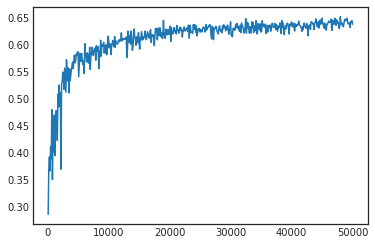

In [28]:
plot_od(model.col_dict['corr_0'])

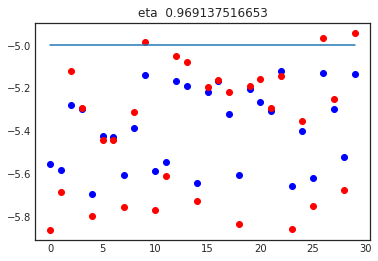

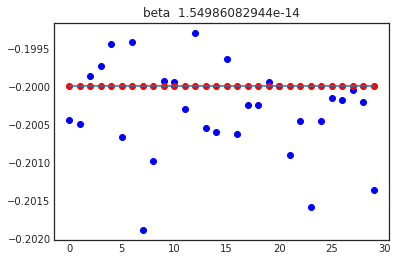

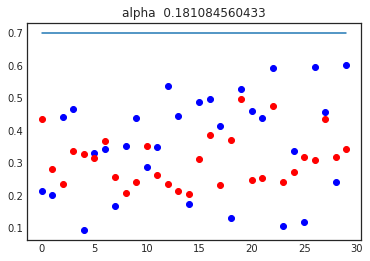

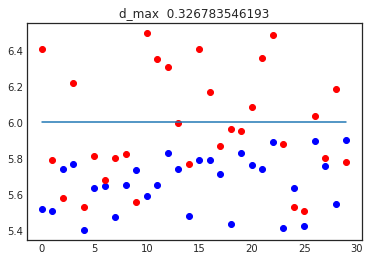

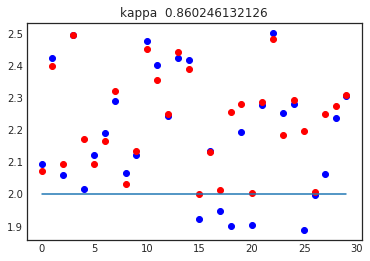

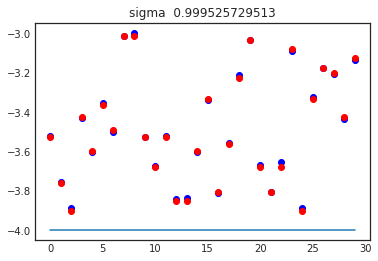

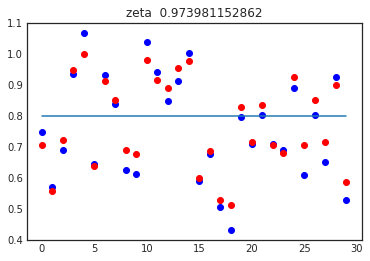

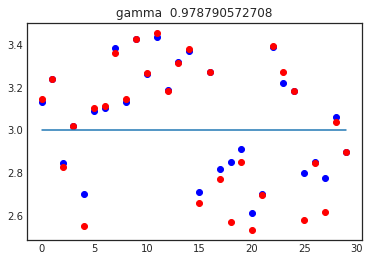

In [22]:
for p in init_params.keys():
    if p is not 'sigma':
        true = [np.array(truths[c][p]).max() for c in range(n_cells)]
    else:
        true =  [inv_softp(np.array(truths[c][p]).max()) for c in range(n_cells)]
    learned = [np.array(model.mgen.genparam_dicts[c][p]).max() for c in range(n_cells)]
    plt.figure()
    plt.plot(learned,'bo')
    plt.plot(true,'ro')
    plt.plot([0,n_cells-1],[init_params[p],init_params[p]])
    plt.title(p + '  ' + str(np.corrcoef(true,learned)[0,1]))
    plt.show()

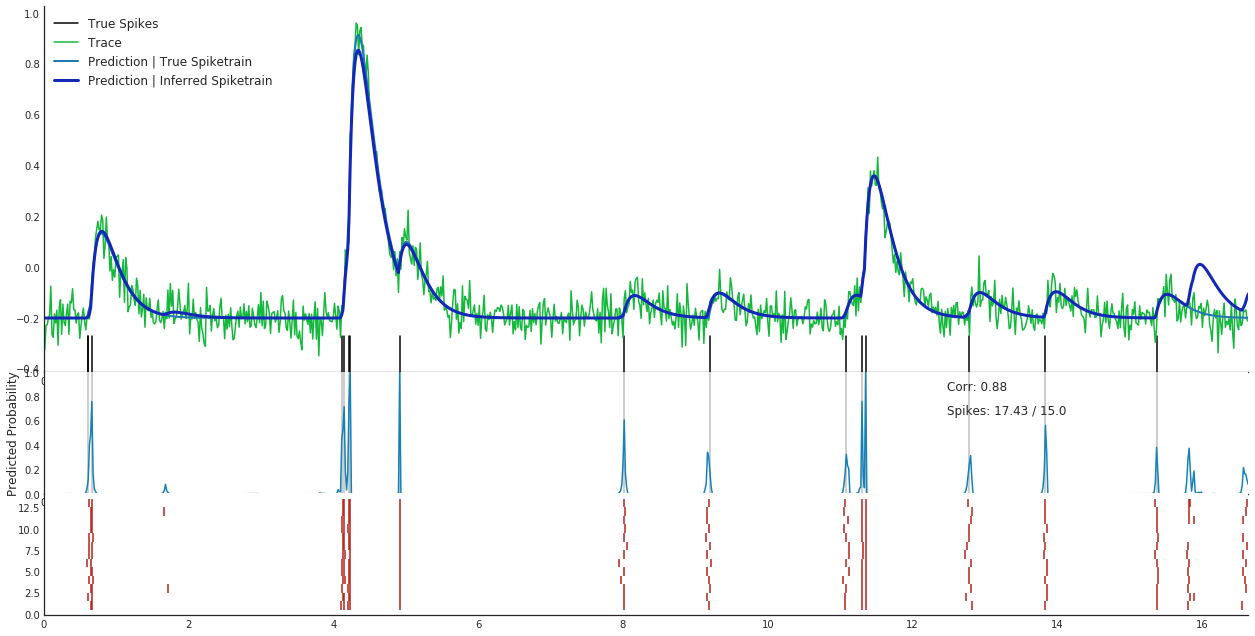

In [27]:
plot_preds_bl(model,data,8,trace=1,figsize=(25,9))